Source code from:
https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gat.py

In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
    
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [2]:
dataset = 'PPI'
path = osp.join(osp.dirname(osp.realpath('__file__')), 'data', dataset)
dataset = PPI(path)
data = dataset[0]

train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [3]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PPI(20):
Number of graphs: 20
Number of features: 50
Number of classes: 121


In [4]:
#data = dataset[0]  # Get the first graph object.

#print(data)
#print('==============================================================')

# Gather some statistics about the graph.
#print(f'Number of nodes: {data.num_nodes}')
#print(f'Number of edges: {data.num_edges}')
#print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Number of validation nodes: {data.test_mask.sum()}')
#print(f'Number of test nodes: {data.val_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
#print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
#print(f'Contains self-loops: {data.contains_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')

In [5]:
#output = torch.bitwise_or(data.test_mask, data.train_mask)
#out = torch.bitwise_or(output, data.val_mask)
#print(out.sum())

In [5]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[   0,  372],
        [   0, 1101],
        [   0,  766],
        ...,
        [1744, 1745],
        [1745, 1744],
        [1749, 1739]])


In [6]:
#visualize(data.x, color=data.y)

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
labels = data.y.clone().detach().cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [9]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return out

In [10]:
@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs

In [11]:
for epoch in range(1, 201):
    out = train(data)
    train_acc, val_acc, test_acc = test(data)
    if epoch % 10 == 0:
        #visualize(out, color=labels)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 010, Train: 0.8714, Val: 0.6880, Test: 0.6900
Epoch: 020, Train: 0.9214, Val: 0.7960, Test: 0.8210
Epoch: 030, Train: 0.9429, Val: 0.7760, Test: 0.7640
Epoch: 040, Train: 0.9500, Val: 0.7640, Test: 0.7590
Epoch: 050, Train: 0.9571, Val: 0.7600, Test: 0.7810
Epoch: 060, Train: 0.9643, Val: 0.8180, Test: 0.8290
Epoch: 070, Train: 0.9571, Val: 0.8120, Test: 0.8110
Epoch: 080, Train: 0.9571, Val: 0.7960, Test: 0.8010
Epoch: 090, Train: 0.9857, Val: 0.8120, Test: 0.8320
Epoch: 100, Train: 0.9714, Val: 0.7900, Test: 0.8000
Epoch: 110, Train: 0.9786, Val: 0.8120, Test: 0.8240
Epoch: 120, Train: 0.9857, Val: 0.8080, Test: 0.8210
Epoch: 130, Train: 0.9857, Val: 0.7920, Test: 0.8220
Epoch: 140, Train: 0.9857, Val: 0.7980, Test: 0.8240
Epoch: 150, Train: 0.9857, Val: 0.7980, Test: 0.8080
Epoch: 160, Train: 0.9857, Val: 0.7980, Test: 0.8200
Epoch: 170, Train: 0.9857, Val: 0.8000, Test: 0.8160
Epoch: 180, Train: 0.9857, Val: 0.8000, Test: 0.8120
Epoch: 190, Train: 0.9929, Val: 0.8060, Test: 

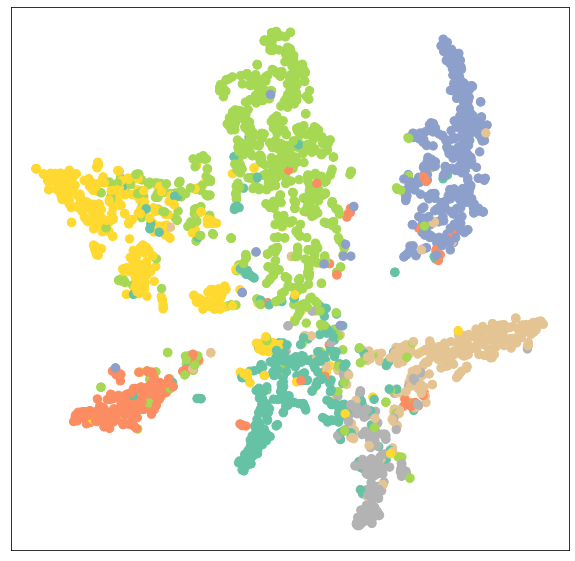

In [12]:
out = model(data.x, data.edge_index)
labels = data.y.clone().detach().cpu()
visualize(out, color=labels)